# DSE Course 1, Session 7: Product Quality Case Study Part 1

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will predict wine quality based on several chemical features. We will highlight key insights about our data being used in our predictive model: things like colinearity between features and feature skewness. For now we will stop at simply assessing the presence of these phenomenon in our data. In later sessions, we will apply strategies to improve our model in light of this phenomenon. 

<br>

---

<br>

<a name='top'></a>

# Contents

* 7.1 [Preparing Environment and Importing Data](#prepare)
  * 7.1.1 [Import Packages](#packages)
  * 7.1.2 [Load Dataset](#dataset)
* 7.2 [Exploratory Data Analysis (EDA)](#eda)
  * 7.2.1 [First Look: Shape, Nulls, Description](#first)
  * 7.2.2 [Descriptive Statistics](#statistics)
    * 7.2.2.1 [Statistics By Type](#type)
    * 7.2.2.2 [Statistcs By Quality](#quality)
  * 7.2.3 [Inferential Statistics](#infer) (ANOVA)
    * 7.2.3.1 [Inference of Feature by Wine Type](#inference1)
    * 7.2.3.2 [Inference of Feature by Quality Label](#inference2)
  * 7.2.4 [Feature Colinearity](#detectcolinearity)
* 7.3 [Feature Engineering](#engineering)
* 7.4 [Modeling](#modeling)
  * 7.4.1 [Wine Type](#winetype)
  * 7.4.2 [Wine Quality](#winequality)

<br>

---


<a name="prepare"></a>
## 7.1 Preparing Environment and Importing Data
[back to top](#top)

<a name='packages'></a>
### 7.1.1 Import Packages
[back to top](#top)

Load libraries which will be needed in this Notebook



In [1]:
# Pandas library for the pandas dataframes
from copy import copy
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import random
import scipy.stats as stats
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
import seaborn as sns
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from ipywidgets import interact, widgets
from statsmodels.formula.api import ols
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



<a name='dataset'></a>
### 7.1.2 Load Dataset
[back to top](#top)


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

df['quality_label'] = df['quality'].apply(lambda x: 'low' if x <=5 else 
                                          'med' if x <= 7 else 'high')
df.columns = df.columns.str.replace(' ', '_')

In [3]:
df.dropna(inplace=True)

In [4]:
class_tp = {'red': 0, 'white': 1}
y_tp = df['type'].map(class_tp)
df['type_encoding'] = y_tp

class_ql = {'low':0, 'med': 1, 'high': 2}
y_ql = df['quality_label'].map(class_ql)
df['quality_encoding'] = y_ql

<a name='eda'></a>
## 7.2 Exploratory Data Analysis (EDA)
[back to top](#top)

<a name='first'></a>
### 7.2.1 First Look: Shape, Nulls, Description
[back to top](#top)

In [5]:
df.shape

(6463, 16)

In [6]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_encoding,quality_encoding
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,7.217755,0.339589,0.318758,5.443958,0.056056,30.516865,115.694492,0.994698,3.218332,0.531150,10.492825,5.818505,0.753520,0.663469
std,1.297913,0.164639,0.145252,4.756852,0.035076,17.758815,56.526736,0.003001,0.160650,0.148913,1.193128,0.873286,0.430995,0.533183
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992330,3.110000,0.430000,9.500000,5.000000,1.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000,1.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000,2.000000


In [7]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,type_encoding,quality_encoding
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,med,1,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,med,1,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,med,1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,med,1,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,med,1,1


<a name='statistics'></a>
### 7.2.2 Descriptive Statistics
[back to top](#top)

In [8]:
def desc(mydf, group=None, target=None):
  if group == None:
    skew = mydf.skew()
    kurt = mydf.kurtosis()
    pear = mydf.corr()['quality']
    spear = mydf.corr('spearman')['quality']
    null = mydf.isnull().sum()
    med = mydf.median()

    dff = pd.DataFrame([skew, kurt, pear, spear, med])
    dff = dff.T
    dff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'median']
  else:
    dff = pd.DataFrame()
    for cat in mydf[group].unique():
      subdf = mydf.loc[mydf[group] == cat]
      subdf = subdf.drop([group],axis=1)
      skew = subdf.skew()
      kurt = subdf.kurtosis()
      pear = subdf.corr()['quality']
      spear = subdf.corr('spearman')['quality']
      null = subdf.isnull().sum()
      med = subdf.median()

      dfff = pd.DataFrame([skew, kurt, pear, spear, med])
      dfff = dfff.T
      dfff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'median']
      arrays = [[cat]*len(list(dfff.index)),list(dfff.index.values)]
      tuples = list(zip(*arrays))
      index = pd.MultiIndex.from_tuples(tuples, names=[group, "feature"])
      dfff.index = index
      dff = pd.concat([dff, dfff])
  return dff

<a name='type'></a>
#### 7.2.2.1 Statistics by Type
[back to top](#top)

In [9]:
desc(df, group='type')

skew   kurtosis  ...  spearman _quality      median
type  feature                                    ...                               
white fixed_acidity         0.644585   2.173205  ...          -0.083449    6.800000
      volatile_acidity      1.580874   5.148436  ...          -0.196844    0.260000
      citric_acid           1.292428   6.233045  ...           0.017883    0.320000
      residual_sugar        1.078719   3.495918  ...          -0.078980    5.200000
      chlorides             5.033186  37.719886  ...          -0.315718    0.043000
      free_sulfur_dioxide   1.411447  11.513642  ...           0.023857   34.000000
      total_sulfur_dioxide  0.392436   0.580726  ...          -0.196546  134.000000
      density               0.980642   9.824256  ...          -0.346717    0.993735
      pH                    0.463352   0.544051  ...           0.107517    3.180000
      sulphates             0.982551   1.600887  ...           0.033729    0.470000
      alcohol               0.484983  -0.701366  ...           0.440659   10.400000
      quality               0.155094   0.218710  ...           1.000000    6.000000
      type_encoding         0.000000   0.000000  ...                NaN    1.000000
      quality_encoding     -0.125266  -0.614522  ...           0.902184    1.000000
red   fixed_acidity         0.980441   1.130584  ...           0.114208    7.900000
      volatile_acidity      0.673387   1.220743  ...          -0.381244    0.520000
      citric_acid           0.313999  -0.790386  ...           0.213988    0.260000
      residual_sugar        4.537260  28.549070  ...           0.034202    2.200000
      chlorides             5.674939  41.609076  ...          -0.187324    0.079000
      free_sulfur_dioxide   1.256757   2.069065  ...          -0.058698   14.000000
      total_sulfur_dioxide  1.516609   3.815485  ...          -0.198511   38.000000
      density               0.066754   0.937021  ...          -0.175657    0.996750
      pH                    0.197771   0.820555  ...          -0.042450    3.310000
      sulphates             2.432711  11.718472  ...           0.377539    0.620000
      alcohol               0.866529   0.212027  ...           0.479155   10.200000
      quality               0.221927   0.295728  ...           1.000000    6.000000
      type_encoding         0.000000   0.000000  ...                NaN    0.000000
      quality_encoding      0.058656  -1.441290  ...           0.939096    1.000000

[28 rows x 5 columns]

<a name='quality'></a>
#### 7.2.2.2 Statistics by Quality
[back to top](#top)

In [10]:
descdf = desc(df, group='quality_label')
descdf

skew  ...    median
quality_label feature                         ...          
med           fixed_acidity         1.796822  ...    6.9000
              volatile_acidity      1.519565  ...    0.2700
              citric_acid           0.685672  ...    0.3100
              residual_sugar        1.697878  ...    3.0000
              chlorides             4.439591  ...    0.0450
              free_sulfur_dioxide   0.632236  ...   29.0000
              total_sulfur_dioxide -0.058202  ...  116.0000
              density               0.991650  ...    0.9940
              pH                    0.360759  ...    3.2100
              sulphates             1.415138  ...    0.5100
              alcohol               0.244318  ...   10.8000
              quality               1.003656  ...    6.0000
              type_encoding        -1.395817  ...    1.0000
              quality_encoding      0.000000  ...    1.0000
low           fixed_acidity         1.655246  ...    7.1000
              volatile_acidity      1.251235  ...    0.3375
              citric_acid           0.362612  ...    0.2950
              residual_sugar        1.078420  ...    2.9000
              chlorides             5.470290  ...    0.0525
              free_sulfur_dioxide   1.795237  ...   26.0000
              total_sulfur_dioxide  0.029223  ...  124.0000
              density              -0.189573  ...    0.9960
              pH                    0.458918  ...    3.2000
              sulphates             2.657837  ...    0.5000
              alcohol               1.168333  ...    9.6000
              quality              -3.203327  ...    5.0000
              type_encoding        -0.807964  ...    1.0000
              quality_encoding      0.000000  ...    0.0000
high          fixed_acidity         1.308021  ...    6.8000
              volatile_acidity      1.198787  ...    0.2700
              citric_acid           0.536103  ...    0.3200
              residual_sugar        0.975625  ...    4.1000
              chlorides             1.950042  ...    0.0370
              free_sulfur_dioxide   1.136000  ...   34.0000
              total_sulfur_dioxide -0.345481  ...  119.0000
              density               0.927227  ...    0.9918
              pH                    0.172560  ...    3.2300
              sulphates             0.861804  ...    0.4800
              alcohol              -0.856611  ...   12.0000
              quality               6.081806  ...    8.0000
              type_encoding        -2.858180  ...    1.0000
              quality_encoding      0.000000  ...    2.0000

[42 rows x 5 columns]

It would be nice to package this into a bar plot:

In [11]:
def my_fig(metric=descdf.columns):
  fig, ax = plt.subplots(1, 1, figsize=(10,10))
  pd.DataFrame(descdf[metric]).unstack()[metric].T[['high', 'med', 'low']].plot(kind='barh', ax=ax)

In [12]:
df.groupby('quality_encoding').count()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,type_encoding
quality_encoding,,,,,,,,,,,,,,,
0,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372
1,3894,3894,3894,3894,3894,3894,3894,3894,3894,3894,3894,3894,3894,3894,3894
2,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197


In [13]:
interact(my_fig)

interactive(children=(Dropdown(description='metric', options=('skew', 'kurtosis', 'pearsons _quality', 'spearm…

<function __main__.my_fig>

<a name='infer'></a>
### 7.2.3 Inferential Statistics

[back to top](#top)

<a name='inference1'></a>
#### 7.2.3.1 ANOVA with Wine Type

[back to top](#top)



###### Question 1: What is the null hypothesis for this ANOVA?

Let's pause.

> I'm going to do an ANOVA analysis, what do we think of this in the context of yesterday with our margin dataset? What is our null hypothesis?

In [14]:
def type_inf_feature_test(df, dependent, independent):
  gb = df.groupby(independent)[dependent]

  # ANOVA test
  F, p = f_oneway(*[gb.get_group(x) for x in gb.groups])

  # SHAPIRO-WILK check normal distribution of residuals
  model = ols('{} ~ C({})'.format(dependent, independent), data=df).fit()
  w, shapp = stats.shapiro(model.resid)

  # BARTLETT, check homogeneity of variances between groups
  w, bartp = stats.bartlett(*[gb.get_group(x) for x in gb.groups])

  # group medians
  meds = gb.median().values

  return F, p, shapp, bartp, meds

In [15]:
features = list(df.columns[1:-1].values)

features.remove('type_encoding')
features.remove('quality_label')
features.remove('quality')

In [16]:
results = []
for feature in features:
  F, p, shapp, bartp, meds = type_inf_feature_test(df, feature, 'type')
  results.append([feature, F, p, shapp, bartp, meds])
results = pd.DataFrame(results, columns=['feature', 'F', 'ANOVA_p', 'shapiro', 
                                         'bartlett', 'medians'])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate

In [17]:
results

,feature,F,ANOVA_p,shapiro,bartlett,medians
0,fixed_acidity,2025.604769,0.000000e+00,2.242078e-44,0.000000e+00,"[7.9, 6.8]"
1,volatile_acidity,4812.716225,0.000000e+00,4.203895e-45,1.214473e-205,"[0.52, 0.26]"
2,citric_acid,231.256348,2.436614e-51,9.636060e-39,9.002651e-138,"[0.26, 0.32]"
3,residual_sugar,898.194980,6.776719e-185,0.000000e+00,0.000000e+00,"[2.2, 5.2]"
4,chlorides,2304.035345,0.000000e+00,0.000000e+00,0.000000e+00,"[0.079, 0.043]"
5,free_sulfur_dioxide,1858.611861,0.000000e+00,8.407791e-45,6.315370e-106,"[14.0, 34.0]"
6,total_sulfur_dioxide,6225.776205,0.000000e+00,4.915533e-29,6.597120e-33,"[38.0, 134.0]"
7,density,1169.105448,1.153840e-235,9.919000e-37,2.316823e-95,"[0.99675, 0.9937349999999999]"
8,pH,781.421423,1.988118e-162,4.524872e-20,2.729131e-01,"[3.31, 3.18]"
9,sulphates,2005.686772,0.000000e+00,0.000000e+00,6.207029e-94,"[0.62, 0.47]"


In [18]:
[(results['ANOVA_p'] < 0.005) & 
(results['shapiro'] > 0.005) &
(results['bartlett'] > 0.005) ]

[0     False
 1     False
 2     False
 3     False
 4     False
 5     False
 6     False
 7     False
 8     False
 9     False
 10    False
 dtype: bool]

In [19]:
targets = ['type_encoding', 'quality_encoding', 'quality']

In [20]:
def visual_inspec(dependent=features, independent=targets):
  model = ols('{} ~ C({})'.format(dependent, independent), data=df).fit()

  #create instance of influence
  influence = model.get_influence()

  #obtain standardized residuals
  standardized_residuals = influence.resid_studentized_internal

  # res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
  sm.qqplot(standardized_residuals, line='45')
  plt.xlabel("Theoretical Quantiles")
  plt.ylabel("Standardized Residuals")
  plt.show()

  # histogram
  plt.hist(model.resid, bins='auto', histtype='bar', ec='k') 
  plt.xlabel("Residuals")
  plt.ylabel('Frequency')
  plt.show()

In [21]:
interact(visual_inspec)

interactive(children=(Dropdown(description='dependent', options=('fixed_acidity', 'volatile_acidity', 'citric_…

<function __main__.visual_inspec>

<a name='inference2'></a>
#### 7.2.3.2 ANOVA with Quality Label
[back to top](#top)

In [22]:
results = []
for feature in features:
  F, p, shapp, bartp, meds = type_inf_feature_test(df, feature, 'quality_label')
  results.append([feature, F, p, shapp, bartp, meds])
results = pd.DataFrame(results, columns=['feature', 'F', 'ANOVA_p', 'shapiro', 
                                         'bartlett', 'medians'])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate

In [23]:
results

,feature,F,ANOVA_p,shapiro,bartlett,medians
0,fixed_acidity,20.087725,2.009220e-09,0.000000e+00,9.279930e-03,"[6.8, 7.1, 6.9]"
1,volatile_acidity,251.318089,7.797842e-106,0.000000e+00,1.894594e-66,"[0.27, 0.3375, 0.27]"
2,citric_acid,18.669946,8.224111e-09,3.550208e-37,2.589670e-33,"[0.32, 0.295, 0.31]"
3,residual_sugar,2.939916,5.294093e-02,0.000000e+00,1.357015e-03,"[4.1, 2.9, 3.0]"
4,chlorides,120.762254,3.237965e-52,0.000000e+00,3.141517e-137,"[0.037000000000000005, 0.052500000000000005, 0..."
5,free_sulfur_dioxide,10.215193,3.720478e-05,4.203895e-45,9.061965e-26,"[34.0, 26.0, 29.0]"
6,total_sulfur_dioxide,7.801483,4.129943e-04,1.901741e-27,6.114725e-21,"[119.0, 124.0, 116.0]"
7,density,283.224671,1.241690e-118,2.583915e-35,8.234671e-33,"[0.9918, 0.996, 0.9940000000000001]"
8,pH,1.088713,3.367114e-01,2.865172e-19,8.784665e-01,"[3.23, 3.2, 3.21]"
9,sulphates,6.749175,1.180127e-03,0.000000e+00,4.077319e-03,"[0.48, 0.5, 0.51]"


In [24]:
(results['ANOVA_p'] < 0.05) 

0      True
1      True
2      True
3     False
4      True
5      True
6      True
7      True
8     False
9      True
10     True
Name: ANOVA_p, dtype: bool

In [25]:
[(results['ANOVA_p'] < 0.05) & 
# (results['shapiro'] > 0.05) &
(results['bartlett'] > 0.05) ]

[0     False
 1     False
 2     False
 3     False
 4     False
 5     False
 6     False
 7     False
 8     False
 9     False
 10    False
 dtype: bool]

In [26]:
interact(visual_inspec)

interactive(children=(Dropdown(description='dependent', options=('fixed_acidity', 'volatile_acidity', 'citric_…

<function __main__.visual_inspec>

#### Question 2: For which ANOVA can we draw conclusions?

> Look at pH distribution of residuals

<a name='detectcolinearity'></a>
#### 7.2.3.2 Feature Colinearity
[back to top](#top)

This is a topic that is easy to debate about, and the correct approach depends entirely on your goal. The main affect of colinearity is to create spurious interactions in your regression coefficients. In other words, interpreting the impact of individual features on your model will be difficult, because the same information can be captured by one or more of these variables. If interpretation is not your goal, it is often safe to proceed even with colinearity among your features. 

Nevertheless its worth the discussion.

##### 7.2.3.2.1 Pearsons Correlation

[back to top](#top)

In [27]:
# in order to compare with wine type we will need to turn the string/category
# column into a binary mapping
class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(df.type.values) # 1 - White; 0 - Red
df['color'] = y_tp

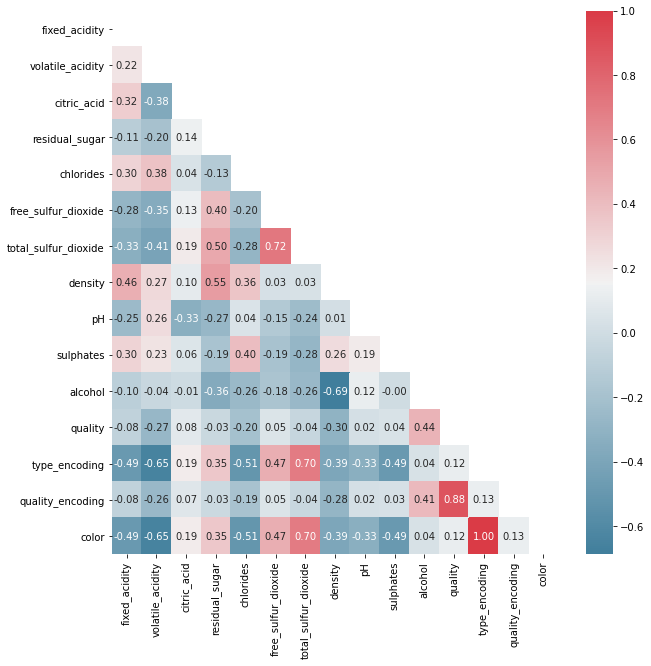

In [28]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize = (10,10))

# create a mask to white-out the upper triangle
mask = np.triu(np.ones_like(df.corr(),
                            dtype=bool))

# we'll want a divergent colormap for this so our eye
# is not attracted to the values close to 0
cmap = sns.diverging_palette(230, 10, as_cmap=True)

sns.heatmap(df.corr(), mask=mask, cmap=cmap,
            ax=ax, annot=True, fmt=".2f")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



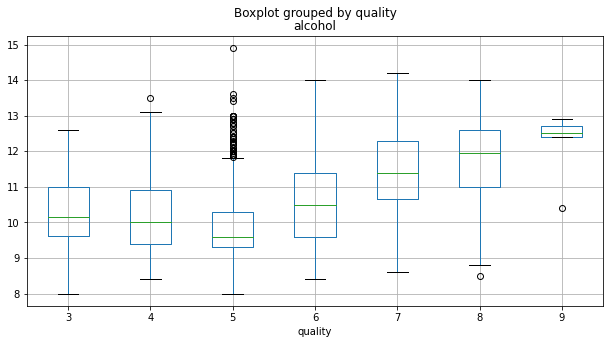

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
df.boxplot(column='alcohol', by='quality', ax=ax)

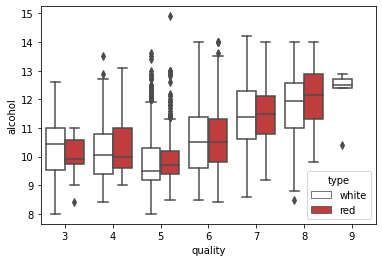

In [30]:
sns.boxplot(x='quality', y='alcohol', hue='type', data=df, 
            palette={"red": "tab:red", "white": "white"})

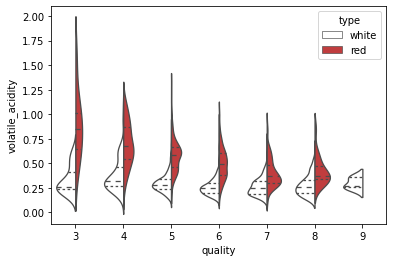

In [31]:
sns.violinplot(x='quality', y='volatile_acidity', hue='type', data=df, 
               split=True, inner='quart', linewidth=1.3,
               palette={'red': 'tab:red', 'white': 'white'})

##### 7.2.3.2.2 Variance Inflation Factor

[back to top](#top)

The **Variance Inflation Factor (VIF)** is a measure of collinearity among predictor variables within a multiple regression. It is  calculated for each predictor by doing a linear regression of that predictor on all the other predictors, and then obtaining the $R^2$ from that regression.

In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :

$$VIF=\frac{1}{1-R^2}$$

Where, $R^2$ is the coefficient of determination in linear regression. Its value lies between 0 and 1.

We will use the method from [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html#statsmodels.stats.outliers_influence.variance_inflation_factor)

In [32]:
def VIF(df, features):
  # add intercept for OLS in statmodels
  X = df[features].assign(constant=1)

  # Calculate VIF Factors
  vif = pd.DataFrame()
  vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in 
                        range(X.shape[1])]
  vif["features"] = X.columns
  return vif.iloc[:-1].sort_values("VIF Factor") # here I've omitted the intercept

In [33]:
VIF(df, features)

,VIF Factor,features
9,1.540692,sulphates
2,1.607891,citric_acid
4,1.631957,chlorides
1,1.952668,volatile_acidity
5,2.139176,free_sulfur_dioxide
8,2.534099,pH
6,2.939275,total_sulfur_dioxide
10,4.792509,alcohol
0,4.909049,fixed_acidity
3,7.231513,residual_sugar


We can see how our result changes when we remove features

In [34]:
subf = copy(features)
subf.remove('density')
VIF(df, subf)

,VIF Factor,features
8,1.348917,sulphates
9,1.409794,alcohol
7,1.411440,pH
3,1.511822,residual_sugar
4,1.565040,chlorides
2,1.607622,citric_acid
1,1.706242,volatile_acidity
0,1.784592,fixed_acidity
5,2.139015,free_sulfur_dioxide
6,2.845855,total_sulfur_dioxide


We find that we could remove alcohol, residual_sugar, or density from our data and in any case all our VIF factors would then fall below 5, our typical cut off.

<a name='engineering'></a>
## 7.3 Feature Engineering
[back to top](#top)

After performing our EDA, we would typically enfold our findings into our decisions on how to engineer or augment our features. This is the topic of Session 2 in Course 2!

We will cover:

* Feature Skewness
* feature colinearity

with tactics such as: 

* feature normalization and outlier removal
* feature selection
* dimensionality reduction

For now, we will proceed with our dataset as is, and use this as a base model to compare with future, improved, models.

<a name='modeling'></a>
## 7.4 Modeling
[back to top](#top)

First we will make some support functions help us evaluate ours models through a standard. Next, we proceed with the classifications of wines types and next of wines quality labels. We will finalize our quality classification model with a staking approach.

<a name='winetype'></a>
### 7.4.1 Wine Type
[back to top](#top)

Since it is a binary classification task, we try first with a simple logistic regression.

This class implements regularized logistic regression using the 'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle both dense and sparse input.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, features + ['quality']], y_tp,
                                      test_size=0.20, random_state=42)

In [36]:
model = LogisticRegression(penalty='l2',
                           tol=.001,
                           C=.003,
                           class_weight='balanced',
                           solver='sag',
                           max_iter=1e6)

In [37]:
model.fit(X_train, y_train)

LogisticRegression(C=0.003, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000000.0, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='sag', tol=0.001,
                   verbose=0, warm_start=False)

In [38]:
y_pred = model.predict(X_test)

#### 7.4.1.1 Classification Metrics

Recall the accuracy metric we covered in Session 5:

In [39]:
print("Accuracy: {:.2f}".format((len(y_pred)-np.sum(np.abs(y_test-y_pred)))/len(y_pred)))

Accuracy: 0.93


##### 7.4.1.1.1 Precision, Recall, and F-Score

* precision
* recall
* f-score

In [40]:
true_labels = y_test
predicted_labels = y_pred

print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))

Accuracy:  92.88% 
Precision: 93.16% 
Recall:    92.88% 
F1 Score:  92.97% 


##### 7.4.1.1.2 Confusion Matrix

In [41]:
target_names = ['red', 'white']
total_classes = len(target_names)
level_labels = [total_classes*[0], list(range(total_classes))]
cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

In [42]:
cm_frame = pd.DataFrame(data=cm, 
                        columns=pd.MultiIndex(levels=[['Predicted:'], target_names], codes=level_labels), 
                        index=pd.MultiIndex(levels=[['Actual:'], target_names], codes=level_labels)) 
print(cm_frame) 

              Predicted:      
                     red white
Actual: red          289    33
        white         59   912


<a name='winequality'></a>
### 7.4.2 Wine Quality
[back to top](#top)

In [43]:
features

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, features + ['type_encoding']], y_ql,
                                      test_size=0.20, random_state=42)

In [45]:
model = LogisticRegression(penalty='l2',
                           tol=.001,
                           C=.003,
                           class_weight='balanced',
                           solver='sag',
                           max_iter=1e6)

In [46]:
model.fit(X_train, y_train)

LogisticRegression(C=0.003, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000000.0, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='sag', tol=0.001,
                   verbose=0, warm_start=False)

In [47]:
y_pred = model.predict(X_test)

In [48]:
print("Accuracy: {:.2f}".format((len(y_pred)-np.sum(np.abs(y_test-y_pred)))/len(y_pred)))

Accuracy: 0.37


In [49]:
true_labels = y_test
predicted_labels = y_pred

print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))

Accuracy:  41.53% 
Precision: 59.43% 
Recall:    41.53% 
F1 Score:  43.20% 


In [50]:
target_names = ['low', 'med', 'high']
total_classes = len(target_names)
level_labels = [total_classes*[0], list(range(total_classes))]
cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

In [51]:
cm_frame = pd.DataFrame(data=cm, 
                        columns=pd.MultiIndex(levels=[['Predicted:'], target_names], codes=level_labels), 
                        index=pd.MultiIndex(levels=[['Actual:'], target_names], codes=level_labels)) 
print(cm_frame) 

             Predicted:          
                    low  med high
Actual: low         337   89   56
        med         244  166  358
        high          2    7   34


## 7.5 Closing Notes for Course 1

We've covered a lot of topics in one week!

One thing we didn't include in our _Build Your Base_ Course was an introduction to _Numpy_. Prior to Course 2, you should get familiar with this package. The following resources are what I recommend:

* [stanford numpy tutorial](https://cs231n.github.io/python-numpy-tutorial/#numpy)

* [machinelearningplus numpy 101](https://www.machinelearningplus.com/python/101-numpy-exercises-python/
)